**Analysis owner**: Felipe Matheus <br>
**Date**: 12/10/2021 <br>
**Related Links**:

The objective of this notebook is to asses data from Jeff and create a DataFrame modeling the problem.

# Index
1. Setup
2. Loading data
3. Plotting data
4. Feature Engineering - Creating DataFrame

# 1. Setup

Libs

In [1]:
import os
import sys
import json
import itertools
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
#import warnings

%load_ext autoreload
%autoreload 2

Modules

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.DataLoader import DataLoader
from src.processing.Processing import Processing
from src.visualization.Plots import Plots
from src.feature_engineering.FeatureEngineering import FeatureEngineering
from src.utils import read_files

Variables

In [3]:
pd.options.display.max_rows = 6
# warnings.filterwarnings("ignore")
with open('../config/variables.json') as json_file:
    var = json.load(json_file)
RAW_DATA = var.get('RAW_DATA')
TRAIN_FOLDER = var.get('TRAIN_FOLDER')
TEST_FOLDER = var.get('TEST_FOLDER')

Objects

In [4]:
load = DataLoader(RAW_DATA)
processing = Processing()
plots = Plots()
feng = FeatureEngineering()

# 2. Loading data

In [5]:
fits = load.load_fits(read_files(RAW_DATA))
energies = processing.get_energy_dict(fits)

In [6]:
energies

{'sp': array([ 72.42276372,  76.79458866, 152.93108048, ...,  59.78663842,
         68.28175692, 165.50336178]),
 'ba': array([79.2461234 , 32.05256775, 82.40269725, ..., 23.9200605 ,
        34.94371734, 10.8930531 ]),
 'cs': array([31.3336658 ,  9.0872523 , 12.90240315, ...,  9.4992777 ,
        22.68337052, 29.00606452]),
 'bd': array([ 70.5295808 , 339.49916514,  51.57864558, ...,  29.3239512 ,
        168.7988886 , 123.45042534]),
 'co': array([ 16.5188232 ,  25.5491515 ,  56.8609797 , ..., 119.90803846,
        118.33637915, 121.63595295]),
 'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
        120.36540315,  19.78994792]),
 'am': array([58.56808924, 59.71696083, 17.71015428, ..., 51.02839084,
         8.4234955 , 36.1971228 ])}

In [7]:
len(tuple(map(dict, itertools.combinations(energies.items(), 2))))

21

In [99]:
#energies_tuple = processing.get_energy_tuple(fits)
#energies_tuple
#len(tuple(map(tuple, itertools.combinations(energies_tuple, 2))))

21 possible combinations

Assessing if they have the same lenght

In [9]:
for key in energies.keys():
    print(len(energies[key]))

658548
15852843
14217618
135563
3394654
12487896
9220770


The lowest possible sum will be: <br>
3394654 <br>
0135563 + <br>
<br>
3530217

# 3. Plotting Data

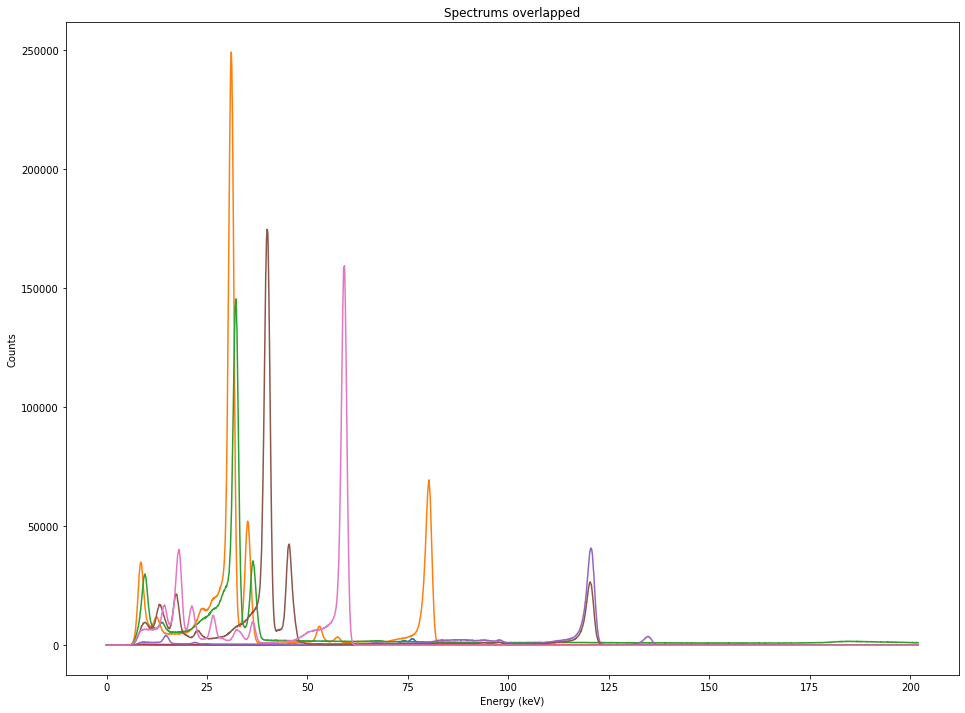

In [8]:
plots.plot_spectrums_overlapping(energies, "Spectrums overlapped")

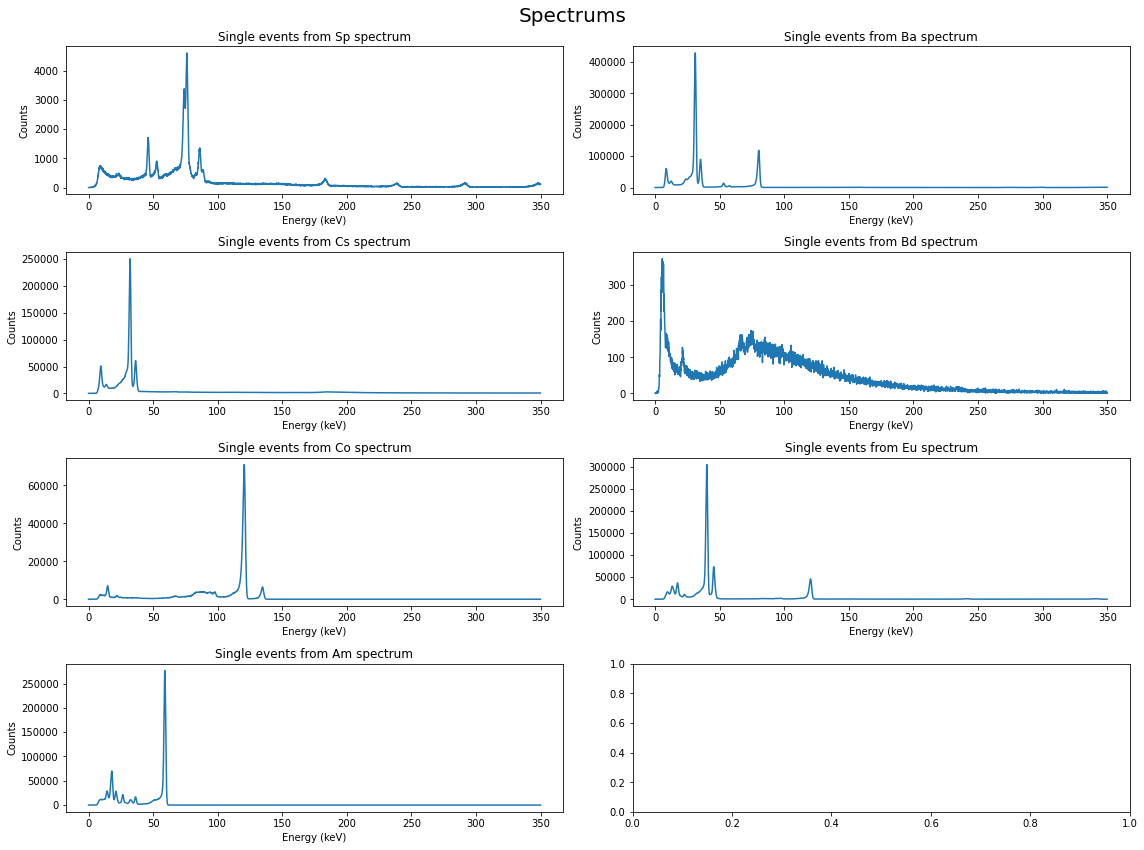

In [30]:
plots.plot_spectrums(energies, "Spectrums")

# 4. Feature Engineering - Creating DataFrame

Idea is to have around half million data to train (each model or all of them?)

## Variables and Hyperparameters

- Each mixed sample will have size of $3530217/reduction factor$ , because it is the lowest possible lenght (which would be Bd source with Co source).
- We need to add a reduction factor because if it would be 1, the model would always guess right the combination Bd with Co.
- The bigger the reduction factor, harder will be for the model. So we expect our accuracy will be inversely proportional to this reduction factor.
- Another hyperparameter set: number of bins. By only looking the graphics, we will choose 600 bins, from 0 to 300 considering each half.

#### Important Observation: What happen if 2 photons from 2 different sources hit the same pixel at the same time? Does it count as a sum?

## Declaring Hyperparameters

In [10]:
REDUCTION_FACTOR = 4

## Declaring Variables

In [11]:
MINIMUM_COMBINATION_LENGHT = len(energies["bd"]) + len(energies["co"])
OUTPUT_SIZE = MINIMUM_COMBINATION_LENGHT//REDUCTION_FACTOR
HALF_OUTPUT_SIZE = OUTPUT_SIZE//2

## 4.1 Mixing Numpy arrays of 2 different energies source
Measuring time of the biggest case

In [37]:
HALF_OUTPUT_SIZE

441277

In [34]:
%%time
elem1 = "ba"
elem2 = "cs"
combination = feng.mix_numpy_arrays_comp_list(
    tuple_arrays=(energies[elem1], energies[elem2]),
    tuple_amounts=(HALF_OUTPUT_SIZE, HALF_OUTPUT_SIZE)
)

CPU times: user 20.1 ms, sys: 0 ns, total: 20.1 ms
Wall time: 19.7 ms


In [38]:
len(combination)

882554

### Visualizing combination

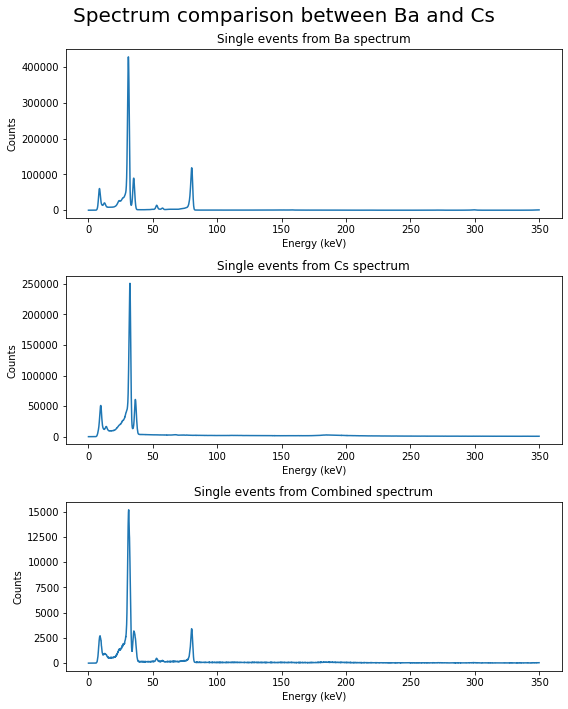

In [35]:
plots.plot_spectrums(
    energies_dict={elem1:energies[elem1], elem2:energies[elem2], "Combined": combination},
    title="Spectrum comparison between Ba and Cs",
    figsize=(8,10),
    ncols=1
)

## 4.2 Counting Bins

In [32]:
%%time
elem1 = "ba"
elem2 = "cs"
_ = feng.count_bins(
    feng.mix_numpy_arrays_comp_list(
        tuple_arrays=(energies[elem1], energies[elem2]),
        tuple_amounts=(HALF_OUTPUT_SIZE, HALF_OUTPUT_SIZE)
    )
)

CPU times: user 65.6 ms, sys: 0 ns, total: 65.6 ms
Wall time: 86.4 ms


In [121]:
%%time
elem1 = "ba"
elem2 = "cs"
percentages = feng.count_bins_percentage(
    feng.mix_numpy_arrays_comp_list(
        tuple_arrays=(energies[elem1], energies[elem2]),
        tuple_amounts=(HALF_OUTPUT_SIZE, HALF_OUTPUT_SIZE)
    ).round().astype(str)
)

CPU times: user 656 ms, sys: 91.6 ms, total: 747 ms
Wall time: 753 ms


considering the time of 753 ms per iteration, if we want to make a DataFrame of N rows, we need to iterate N/21 times. 

Once 21 is the number of combinations 7 choose 2.

## 4.3 Iterating

In [142]:
%%time
combination_dict = feng.gen_mixed_energies_dict(
    energies_dict=energies,
    photons_amount=HALF_OUTPUT_SIZE,
    amount_per_combination=1
)

Starting iteration through: 
 {'sp': array([ 72.42276372,  76.79458866, 152.93108048, ...,  59.78663842,
        68.28175692, 165.50336178]), 'ba': array([79.2461234 , 32.05256775, 82.40269725, ..., 23.9200605 ,
       34.94371734, 10.8930531 ])} 

Starting iteration through: 
 {'sp': array([ 72.42276372,  76.79458866, 152.93108048, ...,  59.78663842,
        68.28175692, 165.50336178]), 'cs': array([31.3336658 ,  9.0872523 , 12.90240315, ...,  9.4992777 ,
       22.68337052, 29.00606452])} 

Starting iteration through: 
 {'sp': array([ 72.42276372,  76.79458866, 152.93108048, ...,  59.78663842,
        68.28175692, 165.50336178]), 'bd': array([ 70.5295808 , 339.49916514,  51.57864558, ...,  29.3239512 ,
       168.7988886 , 123.45042534])} 

Starting iteration through: 
 {'sp': array([ 72.42276372,  76.79458866, 152.93108048, ...,  59.78663842,
        68.28175692, 165.50336178]), 'co': array([ 16.5188232 ,  25.5491515 ,  56.8609797 , ..., 119.90803846,
       118.33637915, 121.635952

Approximately 15 seconds per 1 iteration (for 21 possibilities)

In [143]:
combination_dict

{'sp_ba_0': {'-0.0': 2.2661502865547035e-06,
  '-1.0': 4.532300573109407e-06,
  '-2.0': 2.2661502865547035e-06,
  '0.0': 3.3992254298320555e-06,
  '1.0': 1.812920229243763e-05,
  '10.0': 0.009827160717644473,
  '100.0': 0.0010480945075315505,
  '101.0': 0.0010276991549525581,
  '102.0': 0.0009733115480752453,
  '103.0': 0.0009687792475021359,
  '104.0': 0.0010005053515139016,
  '105.0': 0.0010152353283765074,
  '106.0': 0.0010344976058122223,
  '107.0': 0.0010288322300958355,
  '108.0': 0.0010344976058122223,
  '109.0': 0.001066223709823988,
  '11.0': 0.007692447147709942,
  '110.0': 0.001017501478663062,
  '111.0': 0.0010458283572449957,
  '112.0': 0.0010548929583912147,
  '113.0': 0.0009755776983618,
  '114.0': 0.0009755776983618,
  '115.0': 0.0009619807966424717,
  '116.0': 0.0009200570163412097,
  '117.0': 0.0008622701840340647,
  '118.0': 0.000985775374651296,
  '119.0': 0.0009415854440634794,
  '12.0': 0.008623834915483925,
  '120.0': 0.0008294110048790216,
  '121.0': 0.000889463

## 4.4 Transforming into DataFrame

Example:

In [138]:
pd.DataFrame.from_dict(
    {
    "sm":percentages,
    "sn":percentages
    }, orient='index'
)

,10.0,100.0,101.0,102.0,103.0,104.0,105.0,106.0,107.0,108.0,...,905.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0
sm,0.018528,0.000679,0.000633,0.000625,0.000687,0.000688,0.000704,0.000709,0.000722,0.000672,...,0.000001,0.000684,0.000699,0.000691,0.000687,0.000722,0.000672,0.000652,0.000624,0.000657
sn,0.018528,0.000679,0.000633,0.000625,0.000687,0.000688,0.000704,0.000709,0.000722,0.000672,...,0.000001,0.000684,0.000699,0.000691,0.000687,0.000722,0.000672,0.000652,0.000624,0.000657


In [136]:
pd.DataFrame.from_dict(combination_dict, orient='index')

,-0.0,-1.0,-2.0,0.0,1.0,10.0,100.0,101.0,102.0,103.0,...,99.0,937.0,941.0,1060.0,1114.0,1127.0,1172.0,967.0,990.0,945.0
sp_ba_0,0.000003,0.000002,0.000001,0.000005,0.000020,0.009848,0.000973,0.000994,0.001091,0.000989,...,0.000952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp_ba_1,0.000005,NaN,NaN,0.000003,0.000012,0.009953,0.001073,0.000976,0.001107,0.000965,...,0.000952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp_cs_0,0.000002,0.000001,0.000001,0.000007,0.000019,0.017134,0.001576,0.001531,0.001502,0.001485,...,0.001509,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cs_am_0,NaN,NaN,NaN,NaN,NaN,0.018063,0.000614,0.000647,0.000569,0.000562,...,0.000581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eu_am_0,NaN,NaN,NaN,NaN,NaN,0.010717,0.000286,0.000247,0.000295,0.000340,...,0.000415,0.000006,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eu_am_1,NaN,NaN,NaN,NaN,NaN,0.010626,0.000272,0.000273,0.000300,0.000307,...,0.000380,0.000006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000001


## Todo Transformar aquela base de dados lá inicial em um DF

In [87]:
df_sr

,event_num,mult,mult_i,time,pixel,x,y,energy,event_type,label
0,0,1,0,0.000000,241,1,15,72.422764,1,SR
1,1,1,0,0.214265,78,14,4,76.794589,1,SR
2,2,1,0,0.257149,215,7,13,152.931080,1,SR
...,...,...,...,...,...,...,...,...,...,...
1304410,-19516,1,0,61444.001697,173,13,10,59.786638,1,SR
1304411,-19515,1,0,61444.097826,193,1,12,68.281757,1,SR
1304412,-19514,1,0,61444.112442,34,2,2,165.503362,1,SR


In [ ]:
# todos os arquivos são os dados reais, mas são pas prises pendant
# la meme condition
#Am -> Amerique
# TP8 -> configuration electronique de 1 a 15
# g0 -> outro parâmetro
# BdF -> bruit de fundo. 
# A gente seleciona
#reveil -> alarm


Text(0.5, 1.0, 'Spectre single events')

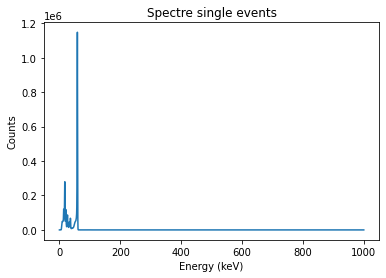

In [4]:
name = data_folder + "Am_proche_TP8_calibrated.fits"
    
hdulist = fits.open(name)

hdr = hdulist[1].header
tabdata = hdulist[1].data
    
hdulist.close()

event_num = tabdata.field("FRAME") #Numéro de l'événement
mult = tabdata.field("MULTIPLICITY") #Multiplicité (nombre de pixels touchés par l'événement)
mult_i = tabdata.field("MULT") #Numéro dans la multiplicité
time = tabdata.field("TIME") #Date de l'événement
pixel = tabdata.field("PIXEL") #Numéro du pixel touché
x = tabdata.field("X") #Coordonnée X du pixel touché
y = tabdata.field("Y") #Coordonnée Y du pixel touché
energy = tabdata.field("ENERGY") #Energie mesurée
event_type = tabdata.field("TYPE") #Ne pas s'occuper de celui-là, la colonne existe mais ne renvoie rien de pertinent

single = (mult == 1)

single_energy = energy[single]

spectre, bins = np.histogram(single_energy,range = (0,1000),bins = 2000)

plt.plot(bins[:-1],spectre)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Spectre single events")


Text(0.5, 1.0, 'Spectre single events')

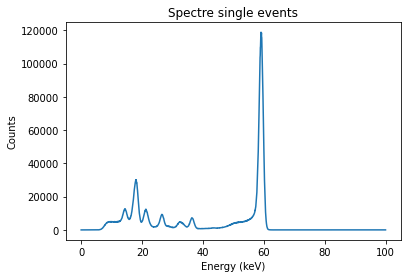

In [6]:
name = data_folder + "Am_proche_TP8_calibrated.fits"
    
hdulist = fits.open(name)

hdr = hdulist[1].header
tabdata = hdulist[1].data
    
hdulist.close()

event_num = tabdata.field("FRAME") #Numéro de l'événement
mult = tabdata.field("MULTIPLICITY") #Multiplicité (nombre de pixels touchés par l'événement)
mult_i = tabdata.field("MULT") #Numéro dans la multiplicité
time = tabdata.field("TIME") #Date de l'événement
pixel = tabdata.field("PIXEL") #Numéro du pixel touché
x = tabdata.field("X") #Coordonnée X du pixel touché
y = tabdata.field("Y") #Coordonnée Y du pixel touché
energy = tabdata.field("ENERGY") #Energie mesurée
event_type = tabdata.field("TYPE") #Ne pas s'occuper de celui-là, la colonne existe mais ne renvoie rien de pertinent

single = (mult == 1)

single_energy = energy[single]

spectre, bins = np.histogram(single_energy,range = (0,100),bins = 2000)

plt.plot(bins[:-1],spectre)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Spectre single events")


In [ ]:
on reste avec la multiplicite 1, e melanja com o americium e barium
mistrurar os bagulhos e dai dizer quais que tem
pega esse espectro bonitao, melanja com o dos radioativos 

faz uma coisa parecida com o hotel unico, mistura os espectros com uma porcentagem aleatoria
identifica quais espectros eu to misturando, labeliza eles e depois bota pra treinar. Socalhe AutoMLl

In [ ]:
        # for file in files:
        #     hdulist = fits.open(self.folder+file)
        #     ans[f"{file.lower()}_header"]= hdulist[1].header
        #     ans[f"{file.lower()}_tabdata"]= hdulist[1].data
        #     hdulist.close()

        # return ans
